In [1]:
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import numpy
import os
import pandas
import tensorflow

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [2]:
epochs = 60
units = 150

In [3]:
AAPL = pandas.read_csv('data/AAPL_Daily.csv')
AAPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-02-01,0.434643,0.445714,0.434643,0.435893,0.373244,398305600
1,2002-02-04,0.434286,0.455714,0.432143,0.452679,0.387617,522373600
2,2002-02-05,0.448036,0.463929,0.447857,0.454464,0.389146,456887200
3,2002-02-06,0.457143,0.463929,0.431250,0.440536,0.377220,597576000
4,2002-02-07,0.440179,0.451607,0.430000,0.433929,0.371562,347832800


In [4]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3775 entries, 0 to 3774
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3775 non-null   object 
 1   Open       3775 non-null   float64
 2   High       3775 non-null   float64
 3   Low        3775 non-null   float64
 4   Close      3775 non-null   float64
 5   Adj Close  3775 non-null   float64
 6   Volume     3775 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 206.6+ KB


In [5]:
AAPL.keys()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
AAPL = AAPL[['Date', 'Open', 'Low', 'High', 'Close']]

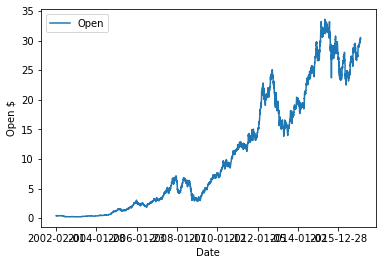

In [7]:
AAPL.plot(x='Date', y=['Open'], xlabel='Date', ylabel="Open $")

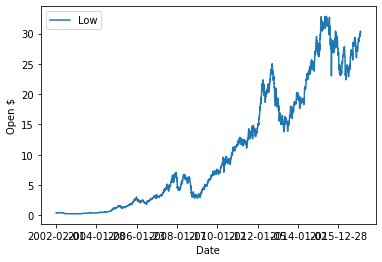

In [8]:
AAPL.plot(x='Date', y=['Low'], xlabel='Date', ylabel="Open $")

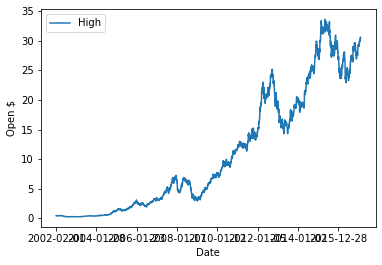

In [9]:
AAPL.plot(x='Date', y=['High'], xlabel='Date', ylabel="Open $")

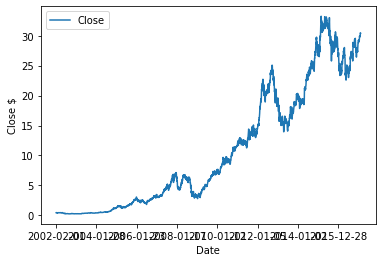

In [10]:
AAPL.plot(x='Date', y=['Close'], xlabel='Date', ylabel="Close $")

In [11]:
AAPL2 = AAPL.copy(deep=True)
AAPL2.set_index('Date', drop=True, inplace=True)
AAPL2.head()

,Open,Low,High,Close
Date,,,,
2002-02-01,0.434643,0.434643,0.445714,0.435893
2002-02-04,0.434286,0.432143,0.455714,0.452679
2002-02-05,0.448036,0.447857,0.463929,0.454464
2002-02-06,0.457143,0.431250,0.463929,0.440536
2002-02-07,0.440179,0.430000,0.451607,0.433929


# Normalization

In [12]:
# Preprocess AAPL data using MinMaxScalar
MMS = MinMaxScaler()
AAPL_scaled = AAPL2.copy()
AAPL_scaled[AAPL_scaled.columns] = MMS.fit_transform(AAPL_scaled)
AAPL_scaled.head()

,Open,Low,High,Close
Date,,,,
2002-02-01,0.006071,0.006361,0.006293,0.006106
2002-02-04,0.006061,0.006284,0.006592,0.006615
2002-02-05,0.006473,0.006766,0.006838,0.006669
2002-02-06,0.006745,0.006257,0.006838,0.006247
2002-02-07,0.006237,0.006218,0.006469,0.006047


# Create Train, Valid and Test Sets

In [13]:
def create_sequences(data, units):
    X, y = [], []
    
    for index in range(units, len(data)):
        X.append(data.iloc[index - units: index].to_numpy())
        y.append(data.iloc[index].to_numpy())
    
    return numpy.array(X), numpy.array(y)

In [14]:
X, y = create_sequences(AAPL_scaled, units)

blockSize = round(len(X) / 5)

trainBlockSize = blockSize * 3
validBlockSize = blockSize
testBlockSize = len(X) - trainBlockSize - validBlockSize

X_train, y_train = X[0:trainBlockSize], y[0:trainBlockSize]
X_valid, y_valid = X[trainBlockSize: trainBlockSize + validBlockSize], y[trainBlockSize: trainBlockSize + validBlockSize]
X_test, y_test = X[trainBlockSize + validBlockSize: trainBlockSize + validBlockSize + testBlockSize], y[trainBlockSize + validBlockSize: trainBlockSize + validBlockSize + testBlockSize]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(2175, 150, 4) (2175, 4) (725, 150, 4) (725, 4) (725, 150, 4) (725, 4)


# LSTM Model

In [15]:
model = Sequential()
model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=units))
model.add(Dropout(0.1))
model.add(Dense(4))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tensorflow.keras.metrics.MeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 150)          93000     
_________________________________________________________________
dropout (Dropout)            (None, 150, 150)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 604       
Total params: 274,204
Trainable params: 274,204
Non-trainable params: 0
_________________________________________________________________


# Training & Validation

In [16]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/60
68/68 [==============================] - 2s 23ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.8083e-04 - val_mean_squared_error: 5.8083e-04
Epoch 2/60
68/68 [==============================] - 1s 14ms/step - loss: 1.4586e-04 - mean_squared_error: 1.4586e-04 - val_loss: 4.2767e-04 - val_mean_squared_error: 4.2767e-04
Epoch 3/60
68/68 [==============================] - 1s 14ms/step - loss: 1.3427e-04 - mean_squared_error: 1.3427e-04 - val_loss: 4.9470e-04 - val_mean_squared_error: 4.9470e-04
Epoch 4/60
68/68 [==============================] - 1s 14ms/step - loss: 1.1675e-04 - mean_squared_error: 1.1675e-04 - val_loss: 6.2011e-04 - val_mean_squared_error: 6.2011e-04
Epoch 5/60
68/68 [==============================] - 1s 14ms/step - loss: 1.2045e-04 - mean_squared_error: 1.2045e-04 - val_loss: 5.6585e-04 - val_mean_squared_error: 5.6585e-04
Epoch 6/60
68/68 [==============================] - 1s 14ms/step - loss: 1.2137e-04 - mean_squared_error: 1.2137e-04 - val_

## Train & Valid Losses

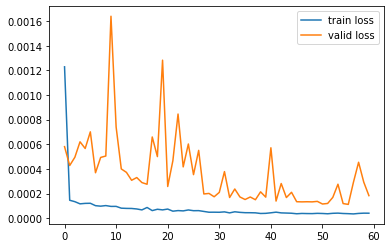

In [17]:
pyplot.plot(range(len(history.history['loss'])), history.history['loss'], label='train loss')
pyplot.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='valid loss')
pyplot.legend()

## Train & Valid Mean Squared Errors

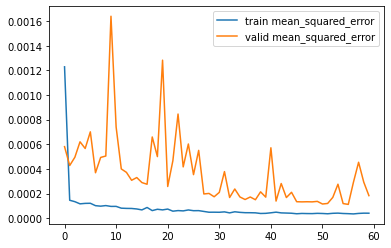

In [18]:
pyplot.plot(range(len(history.history['mean_squared_error'])), history.history['mean_squared_error'], label='train mean_squared_error')
pyplot.plot(range(len(history.history['val_mean_squared_error'])), history.history['val_mean_squared_error'], label='valid mean_squared_error')
pyplot.legend()

# Testing Using Testing Set

In [19]:
y_pred = model.predict(X_test)
y_pred

array([[0.5704599 , 0.58217746, 0.56921256, 0.5716472 ],
       [0.5684642 , 0.58007973, 0.5673179 , 0.56962335],
       [0.56926817, 0.581028  , 0.56813115, 0.570442  ],
       ...,
       [0.9067711 , 0.93537956, 0.8969994 , 0.90921736],
       [0.9128144 , 0.9418936 , 0.90281934, 0.9153297 ],
       [0.915036  , 0.94421744, 0.904909  , 0.91755414]], dtype=float32)

In [20]:
y_pred = MMS.inverse_transform(y_pred)
y_pred

array([[19.275648, 19.219435, 19.24693 , 19.107626],
       [19.209026, 19.151001, 19.183647, 19.040808],
       [19.235865, 19.181936, 19.21081 , 19.067835],
       ...,
       [30.502737, 30.741896, 30.194834, 30.252745],
       [30.70448 , 30.954401, 30.389215, 30.454548],
       [30.778645, 31.030212, 30.45901 , 30.52799 ]], dtype=float32)

In [21]:
results = pandas.concat([AAPL2.iloc[-len(X_test):],
                         pandas.DataFrame(y_pred, columns=['Open_pred', 'Low_pred', 'High_pred', 'Close_pred'], index=AAPL2.iloc[-len(X_test):].index)],
                        axis=1)
results.head()

,Open,Low,High,Close,Open_pred,Low_pred,High_pred,Close_pred
Date,,,,,,,,
2014-03-17,18.846430,18.780357,18.927500,18.812143,19.275648,19.219435,19.246929,19.107626
2014-03-18,18.782143,18.757143,18.998928,18.978571,19.209026,19.151001,19.183647,19.040808
2014-03-19,19.009287,18.892857,19.151428,18.973572,19.235865,19.181936,19.210810,19.067835
2014-03-20,18.924643,18.833929,19.023930,18.882143,19.331423,19.284348,19.304396,19.163897
2014-03-21,18.997499,18.797501,19.062500,19.031071,19.325693,19.278145,19.297367,19.158241


## Testing Results: Open \\$ vs Open_pred \\$

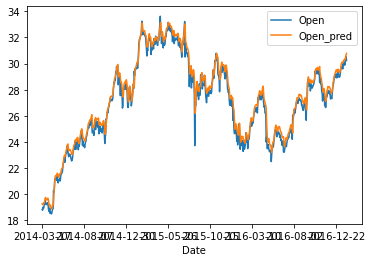

In [22]:
results[['Open', 'Open_pred']].plot()

In [23]:
o_mse = mean_squared_error(results['Open'], results['Open_pred'], squared=True)
print('Mean Squared Error', o_mse)

Mean Squared Error 0.25288709421690325


## Testing Results: Low \\$ vs Low_pred \\$

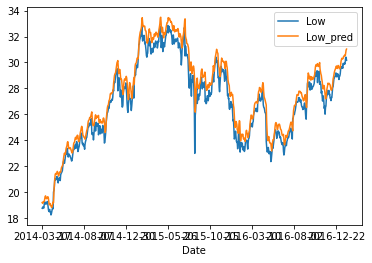

In [24]:
results[['Low', 'Low_pred']].plot()

In [25]:
l_mse = mean_squared_error(results['Low'], results['Low_pred'], squared=True)
print('Mean Squared Error', l_mse)

Mean Squared Error 0.7075441228514379


## Testing Results: High \\$ vs High_pred \\$

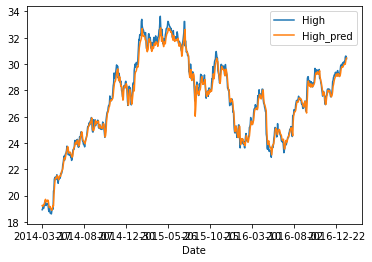

In [26]:
results[['High', 'High_pred']].plot()

In [27]:
h_mse = mean_squared_error(results['High'], results['High_pred'], squared=True)
print('Mean Squared Error', h_mse)

Mean Squared Error 0.16236669502309037


## Testing Results: Close \\$ vs Close_pred \\$

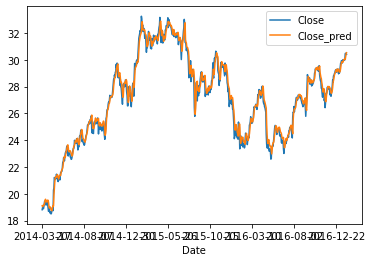

In [28]:
results[['Close', 'Close_pred']].plot()

In [29]:
c_mse = mean_squared_error(results['Close'], results['Close_pred'], squared=True)
print('Mean Squared Error', c_mse)

Mean Squared Error 0.21626562113690884


In [30]:
# uncomment to print training and validation losses and mean squared errors
# history.history

# Forecasting

In [31]:
steps = 30

In [32]:
x = numpy.expand_dims(AAPL_scaled[-units:].to_numpy(), 0)
y_preds = []
for step in range(steps):
    y_pred = model.predict(x)
    y_preds.append(MMS.inverse_transform(y_pred))
    x = numpy.squeeze(x)
    x = numpy.concatenate((x, y_pred), axis=0)
    x = x[1:]
    x = numpy.expand_dims(x, 0)

forecasts = pandas.DataFrame(numpy.squeeze(y_preds), columns = ['Open','Low','High', 'Close'], index=range(len(AAPL), len(AAPL) + steps))
forecasts

,Open,Low,High,Close
3775,30.667572,30.909058,30.349779,30.415274
3776,30.796938,31.048294,30.476576,30.545454
3777,30.956705,31.220812,30.630316,30.705929
3778,31.120810,31.396654,30.787062,30.870211
3779,31.279667,31.565580,30.938339,31.028759
3780,31.430443,31.724897,31.081873,31.178860
3781,31.573074,31.874882,31.217806,31.320574
3782,31.708675,32.016998,31.347267,31.455111
3783,31.838690,32.152954,31.471621,31.583969
3784,31.964441,32.284256,31.592104,31.708530


## Forecasted Open Price

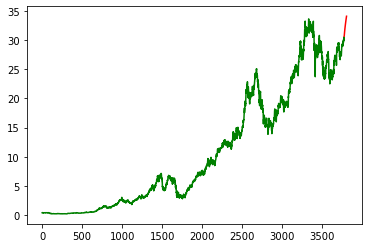

In [33]:
pyplot.plot(AAPL['Date'].index, AAPL['Open'], 'g-')
pyplot.plot(forecasts['Open'], 'r-')

## Forecasted Low Price

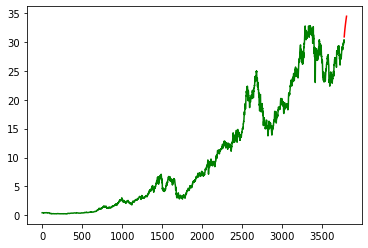

In [34]:
pyplot.plot(AAPL['Date'].index, AAPL['Low'], 'g-')
pyplot.plot(forecasts['Low'], 'r-')

## Forecasted High Price

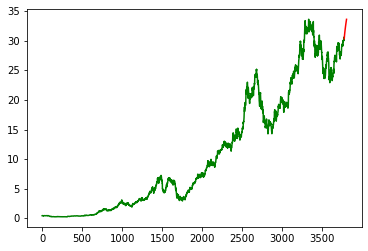

In [35]:
pyplot.plot(AAPL['Date'].index, AAPL['High'], 'g-')
pyplot.plot(forecasts['High'], 'r-')

## Forecasted Close Price

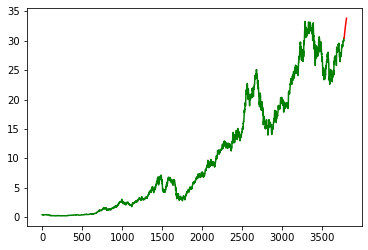

In [36]:
pyplot.plot(AAPL['Date'].index, AAPL['Close'], 'g-')
pyplot.plot(forecasts['Close'], 'r-')